# 02/02/24 3:00 pm. - Looking at the results from running this as a script yesterday (020124_testings_space_jam...)
# 01/31/24 5:47 pm. - I have gotten the mass to make reasonable things. J0037 is running, but I want to run some code overnight and see if it actually is correct... or at least to have it set up. This notebook tests the modules "space_jam" and "total_mass_mge" in e.g. home/shawnknabel/Documents/slacs_kinematics/my_python_packages/space_jam.py
# 02/01/24 10:30 am - Making this a script and actually running it.

In [1]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.switch_backend('agg')
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
#import pickle
import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob

# astronomy/scipy
from astropy.io import fits
#from astropy.wcs import WCS
#from scipy.ndimage import rotate
#from scipy.ndimage import map_coordinates
#from scipy.optimize import least_squares as lsq
#from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
#from scipy.interpolate import interp1d
#from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")


################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [2]:
# bring in the space_jam and total_mass_mge modules

from space_jam import space_jam
from total_mass_mge import total_mass_mge

In [3]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']

# J0029

In [5]:
jam_date = '2024_02_01'
run_id = 'v2.2'

In [76]:
obj_name = obj_names[0]
model_name = f'{obj_name}_{jam_date}_{run_id}'

with open(f'{jam_output_dir}{model_name}/{model_name}_space_jam.pkl', 'rb') as file:
    j0029_jam = pickle.load(file)
    

In [8]:
%matplotlib inline

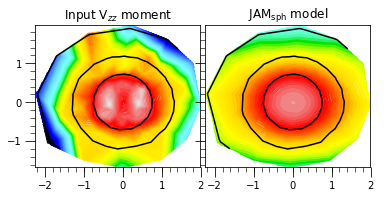

bestfit [2.07259406 0.79391095 0.99356798 0.98568827 0.97097579 5.58207107]


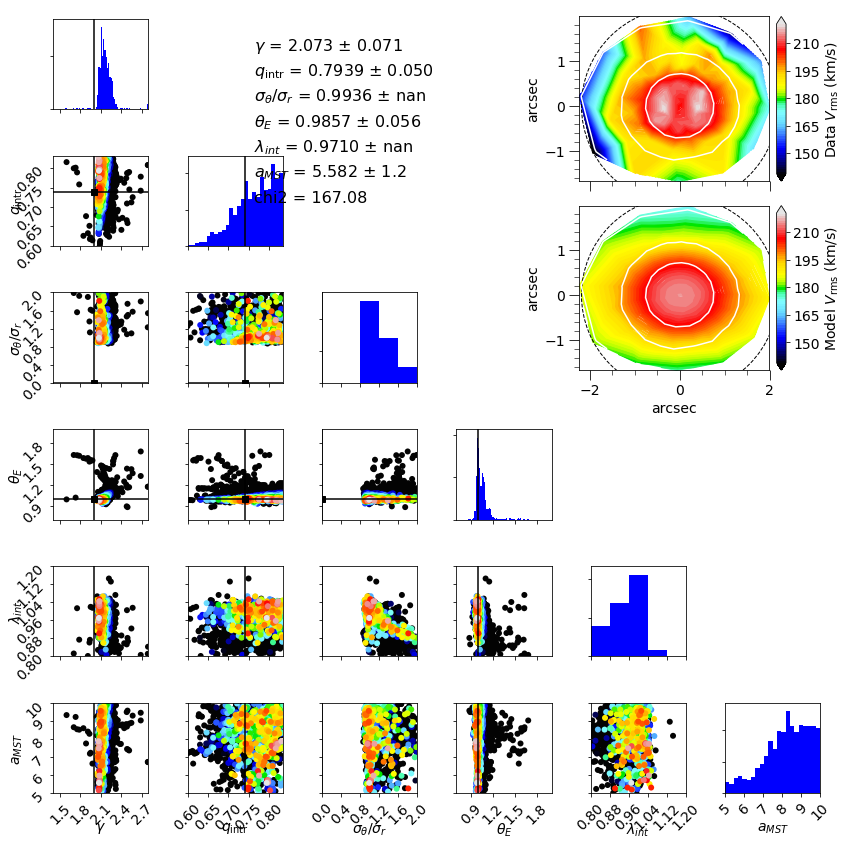

In [9]:
j0029_jam.summary_plot(save=False)

In [10]:
# Modify the summary_plot function to be able to burn

In [14]:
j0029_jam.pars.shape

(6000, 6)

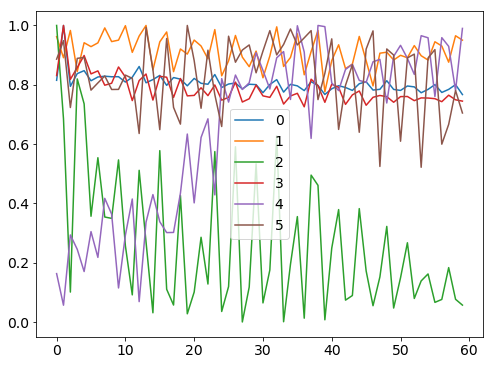

In [19]:
plt.figure(figsize=(8,6))
for i in range(j0029_jam.pars.shape[1]):
    plt.plot(j0029_jam.pars[::100,i]/np.max(j0029_jam.pars[::100,i]), label=i)
plt.legend()

In [81]:
###################
# function to plot summary
def summary_plot_burn(self, save=False, show_convergence=False, burn_notice=None):

    """
    Print the best fitting solution with uncertainties.
    Plot the final corner plot with the best fitting JAM model.
    """

    # jam the best fit
    jam, surf_potential, lambda_int = self.jam_lnprob(self.bestfit, plot=True, test_prior=False, bestfit=True)
    plt.pause(1)
    if jam==0:
        return 'Cannot plot this bestfit'
    rms_model = jam.model
    flux_model = jam.flux

    plot_pars = self.pars.copy()
    plot_bounds = np.array(self.bounds).copy()#self.bounds.copy()
    plot_truths = self.p0.copy()
    #truths should only be for gamma, theta_E and q_intr
    plot_truths[2] = 0
    plot_truths[-1] = 0
    plot_truths[-2] = 0
    # substitute the plot parameters with the ratios and lambda_ints
    plot_pars[:,2] = self.anisotropy_ratio_accepted
    plot_pars[:,-2] = self.lambda_int_accepted
    # bounds should change
    plot_bounds[0][2] = self.shape_anis_bounds[0]
    plot_bounds[1][2] = self.shape_anis_bounds[1]
    plot_bounds[0][-2] = 0.8
    plot_bounds[1][-2] = 1.2
    
    # plot the convergence
    if show_convergence:
        plt.figure(figsize=(8,6))
        for i in range(plot_pars.shape[1]):
            plt.plot(plot_pars[::12,i]/np.max(plot_pars[::12,i]), label=self.labels[i])
        plt.legend()
        plt.pause(1)
    
    # burn # samples as "burn_notice"
    if burn_notice is not None:
        plot_pars = plot_pars[burn_notice:, :]

    # calculate uncertainties in posterior
    plot_bestfit = plot_pars[np.nanargmax(self.lnprob[burn_notice:])]
    print('bestfit', plot_bestfit)
    perc = np.percentile(plot_pars, [15.86, 84.14], axis=0)  # 68% interval
    sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
    chi2_bestfit = self.chi2s[self.index_accepted][np.nanargmax(self.lnprob[burn_notice:])]

    # For plotting, only show the finite probability points
    finite = np.isfinite(self.lnprob[burn_notice:])

    # Produce final corner plot without trial values and with best fitting JAM
    plt.rcParams.update({'font.size': 14})
    plt.clf()
    corner_plot(plot_pars[finite], self.lnprob[burn_notice:][finite], labels=self.labels, extents=plot_bounds, truths=plot_truths, truth_color='k', fignum=1)

    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()
    fig.set_size_inches((12,12))
    fig.tight_layout()

    i = 0                          
    # annotate the model results
    plt.annotate(f'chi2 = {np.around(chi2_bestfit, 2)}', (0.30, 0.97-(1+len(self.labels))*0.03), xycoords='figure fraction', fontsize=16)
    for label, best, sig in zip(self.labels, plot_bestfit, sig_bestfit):
        string = f"{label} = {best:#.4g} ± {sig:#.2g}"
        plt.annotate(string, (0.30, 0.94-i*0.03), xycoords='figure fraction', fontsize=16) 
        i = i+1

    # plot circular reff
    reff_plot = plt.Circle((0,0), self.reff, color='k', fill=False, linestyle='--')

    # plot data
    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = self.Vrms.copy()
    rms1[self.goodbins] = symmetrize_velfield(self.xbin[self.goodbins], self.ybin[self.goodbins], self.Vrms[self.goodbins])
    vmin, vmax = np.percentile(rms1[self.goodbins], [0.5, 99.5])
    plot_velfield(self.xbin, self.ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)

    # plot circular reff again... can only patch one time
    reff_plot = plt.Circle((0,0), self.reff, color='k', fill=False, linestyle='--')

    # plot model
    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(self.xbin, self.ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    #plt.tick_params(labelbottom=False)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)

    if save==True:
        plt.savefig(f'{self.model_dir}{self.obj_name}_corner_plot_{self.model_name}_{self.date_time}.png', bbox_inches='tight')
        plt.savefig(f'{self.model_dir}{self.obj_name}_corner_plot_{self.model_name}_{self.date_time}.pdf', bbox_inches='tight')

    plt.show()
    plt.pause(1)

In [82]:
import types
from adamet.corner_plot import corner_plot
from plotbin.plot_velfield import plot_velfield
from plotbin.symmetrize_velfield import symmetrize_velfield

In [83]:
j0029_jam.summary_plot_burn = types.MethodType(summary_plot_burn, j0029_jam)

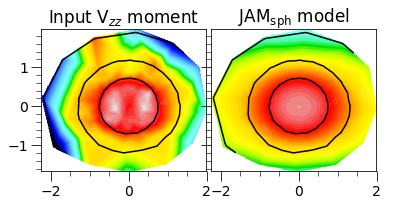

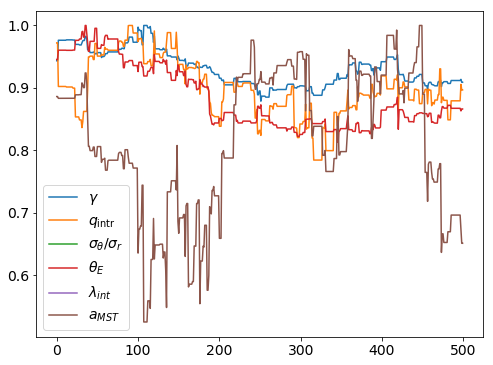

bestfit [2.07259406 0.79391095 0.99356798 0.98568827 0.97097579 5.58207107]


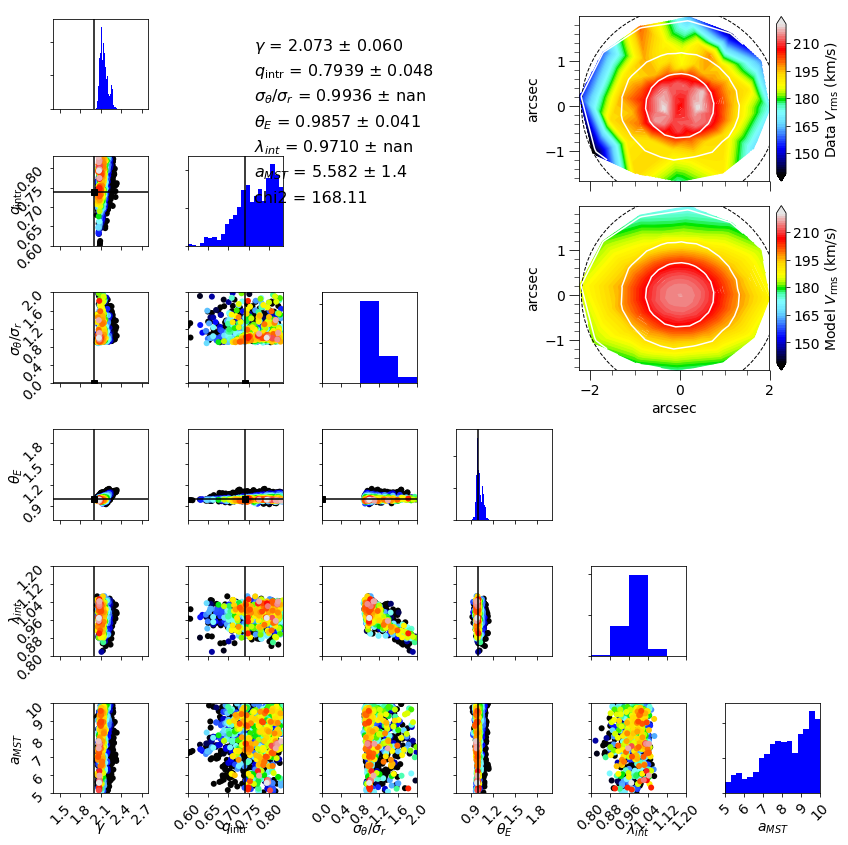

In [84]:
j0029_jam.summary_plot_burn(show_convergence=True, burn_notice=2000)

# J0037

In [86]:
obj_name = obj_names[1]
model_name = f'{obj_name}_{jam_date}_{run_id}'

with open(f'{jam_output_dir}{model_name}/{model_name}_space_jam.pkl', 'rb') as file:
    j0037_jam = pickle.load(file)
    

In [87]:
j0037_jam.summary_plot_burn = types.MethodType(summary_plot_burn, j0037_jam)

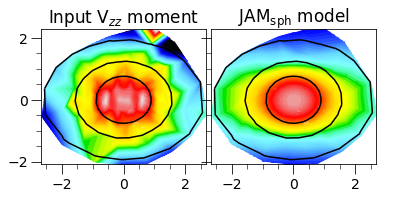

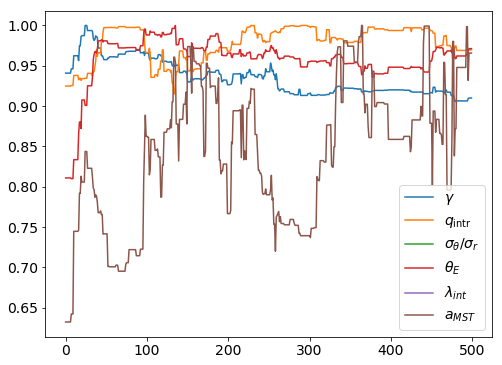

bestfit [2.09874953 0.69716068        nan 1.47645592        nan 6.54866984]


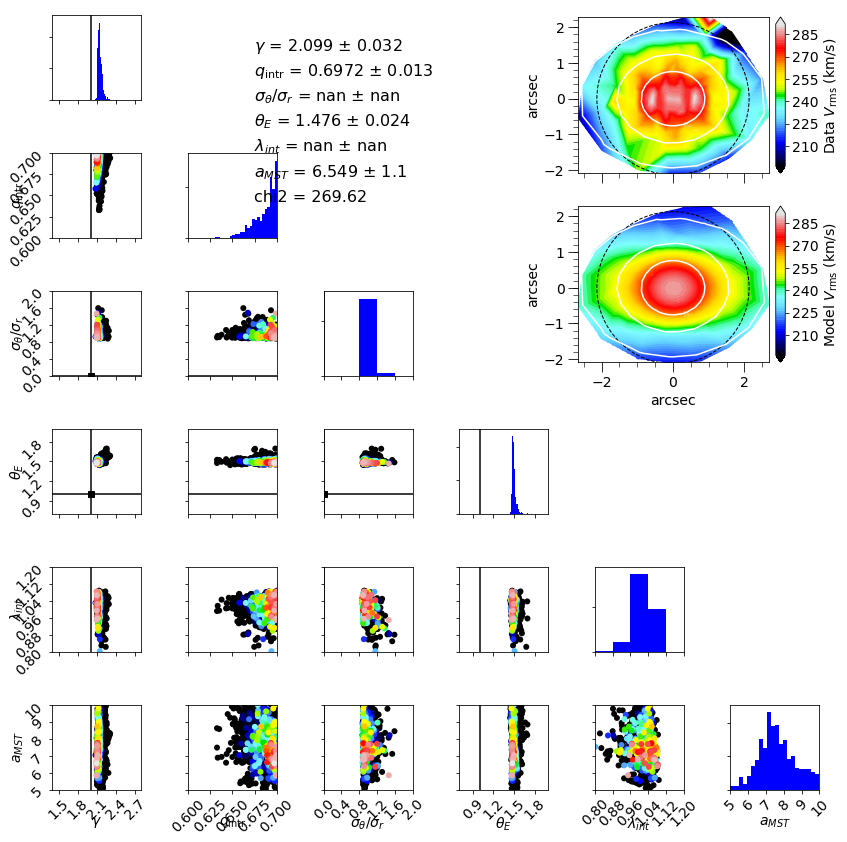

In [88]:
j0037_jam.summary_plot_burn(show_convergence=True, burn_notice=2000)